In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore")

# Set the OMP_NUM_THREADS environment variable to avoid the KMeans memory leak warning
os.environ["OMP_NUM_THREADS"] = "6"

In [2]:
from kneed import KneeLocator

In [3]:
# Loading the dataset
mcdonalds = R"C:\Users\ushik\Downloads\mcdonalds_case_study.csv"
df = pd.read_csv(mcdonalds)

In [4]:
#Inspecting basic features of the dataset
df.columns.tolist()

['yummy',
 'convenient',
 'spicy',
 'fattening',
 'greasy',
 'fast',
 'cheap',
 'tasty',
 'expensive',
 'healthy',
 'disgusting',
 'Like',
 'Age',
 'VisitFrequency',
 'Gender']

In [5]:
df.shape

(1453, 15)

In [6]:
df.head(5)

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male


In [7]:
# Transforming YES/NO to binary numeric values
segmentation_variables = df.iloc[:, :11]  # Extracting the first 11 columns

In [8]:
# Using map to transform YES/NO to 1/0
binary_segmentation = segmentation_variables.replace({"Yes": 1, "No": 0})

In [9]:
# Checking the transformation
print(binary_segmentation)

      yummy  convenient  spicy  fattening  greasy  fast  cheap  tasty  \
0         0           1      0          1       0     1      1      0   
1         1           1      0          1       1     1      1      1   
2         0           1      1          1       1     1      0      1   
3         1           1      0          1       1     1      1      1   
4         0           1      0          1       1     1      1      0   
...     ...         ...    ...        ...     ...   ...    ...    ...   
1448      0           1      0          1       1     0      0      0   
1449      1           1      0          1       0     0      1      1   
1450      1           1      0          1       0     1      0      1   
1451      1           1      0          0       0     1      1      1   
1452      0           1      0          1       1     0      0      0   

      expensive  healthy  disgusting  
0             1        0           0  
1             1        0           0  
2     

In [10]:
# Calculating column means
column_means = binary_segmentation.mean().round(2)
print(column_means)

yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


In [11]:
# Principal components analysis
pca = PCA()
principal_components = pca.fit_transform(binary_segmentation)

In [12]:
# Summary of PCA
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

In [13]:
summary = pd.DataFrame({
    'Standard Deviation': np.sqrt(pca.explained_variance_),
    'Proportion of Variance': explained_variance,
    'Cumulative Proportion': cumulative_variance
    })
print(summary.round(2))

    Standard Deviation  Proportion of Variance  Cumulative Proportion
0                 0.76                    0.30                   0.30
1                 0.61                    0.19                   0.49
2                 0.50                    0.13                   0.63
3                 0.40                    0.08                   0.71
4                 0.34                    0.06                   0.77
5                 0.31                    0.05                   0.82
6                 0.29                    0.04                   0.86
7                 0.28                    0.04                   0.90
8                 0.27                    0.04                   0.94
9                 0.25                    0.03                   0.97
10                0.24                    0.03                   1.00


In [14]:
# Factor loadings
factor_loadings = pd.DataFrame(pca.components_.T, index=segmentation_variables.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
print(factor_loadings.round(2))

             PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  PC10  PC11
yummy      -0.48  0.36 -0.30  0.06 -0.31  0.17 -0.28  0.01  0.57 -0.11  0.05
convenient -0.16  0.02 -0.06 -0.14  0.28 -0.35 -0.06 -0.11 -0.02 -0.67 -0.54
spicy      -0.01  0.02 -0.04  0.20  0.07 -0.36  0.71  0.38  0.40 -0.08  0.14
fattening   0.12 -0.03 -0.32 -0.35 -0.07 -0.41 -0.39  0.59 -0.16 -0.01  0.25
greasy      0.30 -0.06 -0.80  0.25  0.36  0.21  0.04 -0.14 -0.00  0.01  0.00
fast       -0.11 -0.09 -0.06 -0.10  0.11 -0.59 -0.09 -0.63  0.17  0.24  0.34
cheap      -0.34 -0.61 -0.15  0.12 -0.13 -0.10 -0.04  0.14  0.08  0.43 -0.49
tasty      -0.47  0.31 -0.29 -0.00 -0.21 -0.08  0.36 -0.07 -0.64  0.08  0.02
expensive   0.33  0.60  0.02  0.07 -0.00 -0.26 -0.07  0.03  0.07  0.45 -0.49
healthy    -0.21  0.08  0.19  0.76  0.29 -0.18 -0.35  0.18 -0.19 -0.04  0.16
disgusting  0.37 -0.14 -0.09  0.37 -0.73 -0.21 -0.03 -0.17 -0.07 -0.29 -0.04


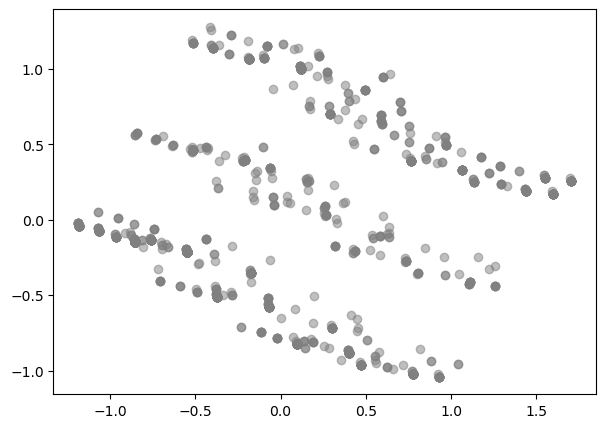

In [15]:
# Plotting the perceptual map
plt.figure(figsize=(7, 5))

# Projection of the data into the first two principal components
plt.scatter(principal_components[:, 0], principal_components[:, 1], color='grey', alpha=0.5)

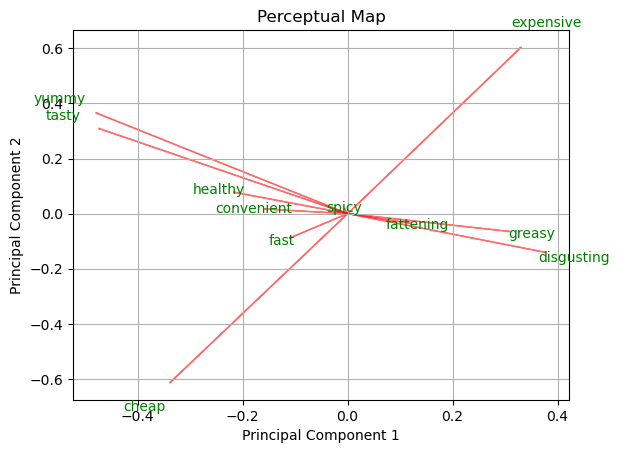

In [16]:
# Adding the rotated and projected original segmentation variables as arrows
for i in range(factor_loadings.shape[0]):
    plt.arrow(0, 0, factor_loadings.iloc[i, 0], factor_loadings.iloc[i, 1],
              color='r', alpha=0.5)
    plt.text(factor_loadings.iloc[i, 0] * 1.15, factor_loadings.iloc[i, 1] * 1.15,
             factor_loadings.index[i], color='g', ha='center', va='center')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Perceptual Map')
plt.grid()

plt.show()

In [17]:
# Function to fit k-means and return labels
def fit_kmeans(n_clusters, data, n_init=10):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=1234)
    return kmeans.fit_predict(data)

In [18]:
# Function to compute k-means clustering solutions for a range of segment numbers
def compute_kmeans_range(data, min_clusters, max_clusters, n_init=10):
    results = {}
    for n_clusters in range(min_clusters, max_clusters + 1):
        labels = [fit_kmeans(n_clusters, data, n_init) for _ in range(10)]
        results[n_clusters] = labels
    return results

In [19]:
# Computing k-means solutions for 2 to 8 clusters
kmeans_results = compute_kmeans_range(binary_segmentation, 2, 8)

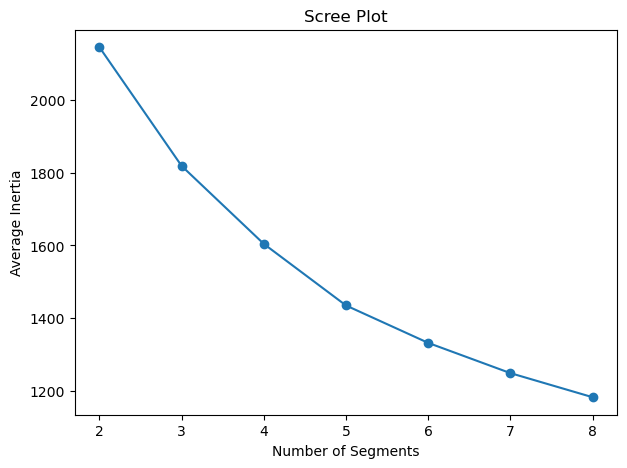

In [20]:
# Plotting the scree plot
inertia = {n_clusters: [KMeans(n_clusters=n_clusters, n_init=10, random_state=1234).fit(binary_segmentation).inertia_ for _ in range(10)] 
           for n_clusters in range(2, 9)}

plt.figure(figsize=(7, 5))
plt.plot(list(inertia.keys()), [np.mean(v) for v in inertia.values()], marker='o')
plt.xlabel("Number of Segments")
plt.ylabel("Average Inertia")
plt.title("Scree Plot")
plt.show()

In [21]:
# Global stability analysis using bootstrapping
def stability_analysis(data, min_clusters, max_clusters, n_bootstrap=100, n_init=10):
    bootstrap_stability = {}
    for n_clusters in range(min_clusters, max_clusters + 1):
        boot_scores = []
        for _ in range(n_bootstrap):
            boot_data = resample(data, replace=True)
            labels = [fit_kmeans(n_clusters, boot_data, n_init) for _ in range(n_init)]
            mean_labels = np.mean(labels, axis=0)
            boot_scores.append(adjusted_rand_score(labels[0], mean_labels))
        bootstrap_stability[n_clusters] = boot_scores
    return bootstrap_stability

In [22]:
# Perform global stability analysis
stability_results = stability_analysis(binary_segmentation, 2, 8, n_bootstrap=20, n_init=5)

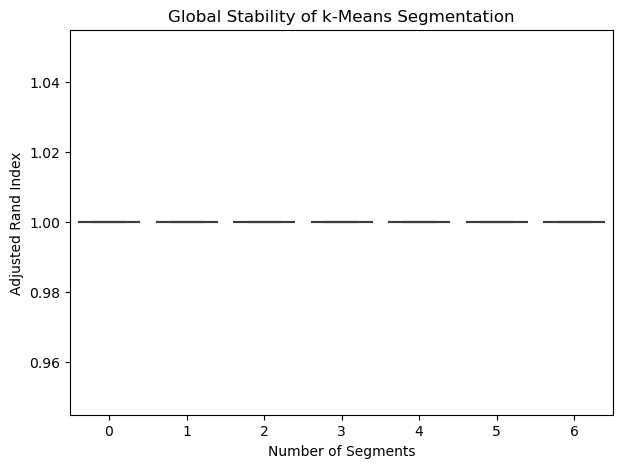

In [23]:
# Plot global stability results
plt.figure(figsize=(7, 5))
sns.boxplot(data=[stability_results[n_clusters] for n_clusters in range(2, 9)])
plt.xlabel("Number of Segments")
plt.ylabel("Adjusted Rand Index")
plt.title("Global Stability of k-Means Segmentation")
plt.show()

In [24]:
# Additional plots for specific segment analysis
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234).fit(binary_segmentation)
labels = kmeans.labels_

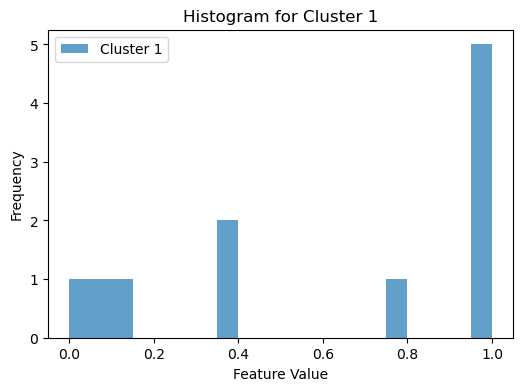

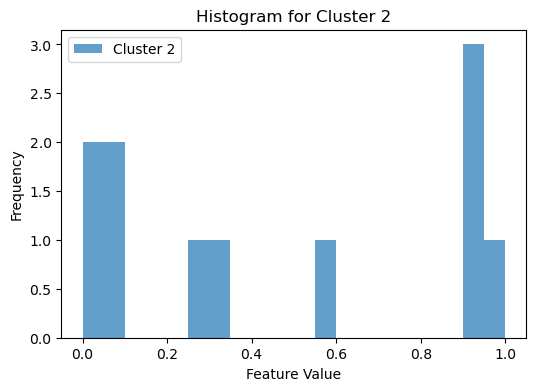

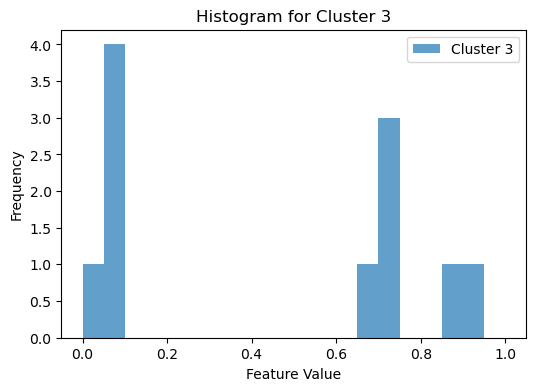

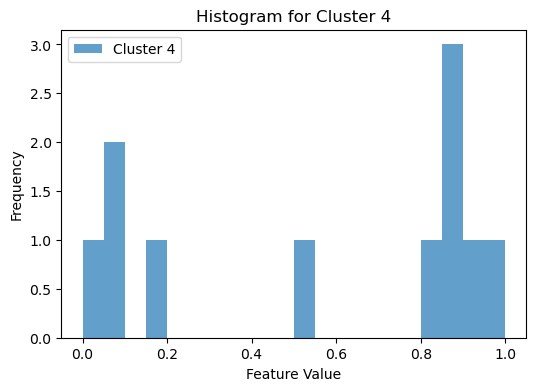

In [25]:
# Plotting histograms of segment distributions
for i in range(n_clusters):
    plt.figure(figsize=(6, 4))
    plt.hist(binary_segmentation[labels == i].mean(axis=0), bins=20, range=(0, 1), alpha=0.7, label=f"Cluster {i + 1}")
    plt.xlabel("Feature Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram for Cluster {i + 1}")
    plt.legend()
    plt.show()

In [26]:
#Inspect segment membership changes
def segment_membership_changes(data, k_range, nrep=10):
    memberships = {}
    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init=nrep, random_state=1234)
        kmeans.fit(data)
        memberships[k] = kmeans.labels_
    return memberships

In [27]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
binary_segmentation_scaled = scaler.fit_transform(binary_segmentation)

In [28]:
k_range = range(2, 9)
memberships = segment_membership_changes(binary_segmentation_scaled, k_range)

In [29]:
#Create SLSA plot
def plot_slsa(memberships):
    plt.figure(figsize=(8, 6))
    for i, (k, labels) in enumerate(memberships.items()):
        plt.subplot(1, len(memberships), i+1)
        plt.hist(labels, bins=np.arange(k+1) - 0.5, alpha=0.75)
        plt.title(f'k={k}')
        plt.xlabel('Segment')
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

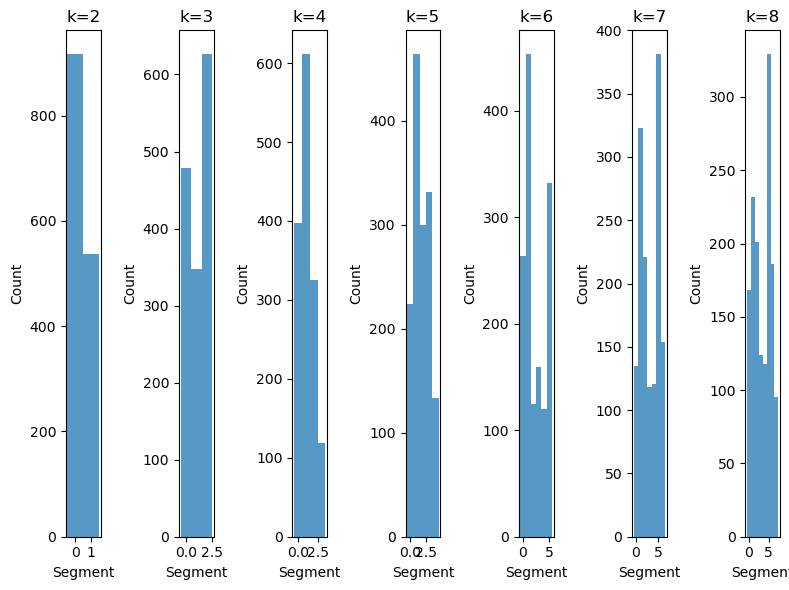

In [30]:
plot_slsa(memberships)

In [31]:
#Selecting and saving the four-segment solution
k4_labels = memberships[4]
bs_k4 = KMeans(n_clusters=4, n_init=10, random_state=1234).fit(binary_segmentation_scaled).labels_

In [32]:
#Calculating SLSW
def calculate_slsw(data, labels, k, nrep=100):
    stability = np.zeros(k)
    for i in range(nrep):
        boot_sample = resample(data, n_samples=len(data))
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
        kmeans.fit(boot_sample)
        for j in range(k):
            idx = np.where(labels == j)[0]
            stability[j] += adjusted_rand_score(labels[idx], kmeans.labels_[idx])
    stability /= nrep
    return stability

In [33]:
slsw_stability = calculate_slsw(binary_segmentation_scaled, bs_k4, 4)

In [34]:
#Plotting SLSW
def plot_slsw(stability):
    plt.figure(figsize=(7, 5))
    plt.bar(range(len(stability)), stability, alpha=0.75)
    plt.ylim(0, 1)
    plt.xlabel('Segment Number')
    plt.ylabel('Segment Stability')
    plt.title('Segment Level Stability Within Solutions')
    plt.show()

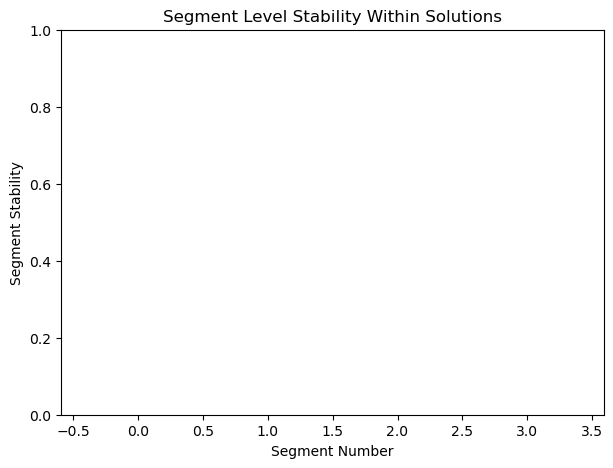

In [35]:
plot_slsw(slsw_stability)

In [36]:
#Setting the random seed
np.random.seed(1234)

In [37]:
models = [GaussianMixture(n_components=k, random_state=1234) for k in range(2, 9)]
results = [model.fit(binary_segmentation) for model in models]

# Extracting criteria
aic = [model.aic(binary_segmentation) for model in models]
bic = [model.bic(binary_segmentation) for model in models]
log_likelihood = [model.score(binary_segmentation) * len(binary_segmentation) for model in models]

# Printing results
for k, (a, b, ll) in enumerate(zip(aic, bic, log_likelihood), start=2):
    print(f'k={k}, AIC={a}, BIC={b}, LogLik={ll}')

k=2, AIC=-16949.054428881427, BIC=-16130.439651028033, LogLik=8629.527214440714
k=3, AIC=-12000.32436370655, BIC=-10769.761504094673, LogLik=6233.162181853275
k=4, AIC=-29284.01004330007, BIC=-27641.499101929712, LogLik=14953.005021650035
k=5, AIC=-27625.162786695524, BIC=-25570.703763566686, LogLik=14201.581393347762
k=6, AIC=-30393.025906904197, BIC=-27926.618802016874, LogLik=15663.512953452098
k=7, AIC=-33247.28904513226, BIC=-30368.933858486456, LogLik=17168.64452256613
k=8, AIC=-43548.28414375951, BIC=-40257.98087535523, LogLik=22397.142071879756


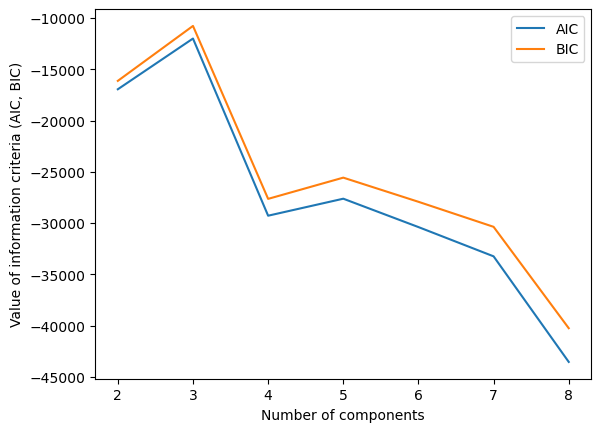

In [38]:
#Plotting the information criteria
k_values = range(2, 9)
plt.plot(k_values, aic, label='AIC')
plt.plot(k_values, bic, label='BIC')
plt.xlabel('Number of components')
plt.ylabel('Value of information criteria (AIC, BIC)')
plt.legend()
plt.show()

In [39]:
# Getting the model with 4 components
best_model = models[2]  # Index 2 corresponds to 4 components

# Getting the mixture model labels
mixture_labels = best_model.predict(binary_segmentation)

# Creating a cross-tabulation
cross_tab = pd.crosstab(labels, mixture_labels)
print(cross_tab)

col_0    0    1    2    3
row_0                    
0       13  299   10  191
1        1    0  176  189
2      113    0   21  108
3       33  127    8  164


In [40]:
# Reinitializing the mixture model using the k-means solution
init_labels = labels

# Fitting the model with the initial labels
reinitialized_model = GaussianMixture(n_components=4, random_state=1234)
reinitialized_model.fit(binary_segmentation, init_labels)

# Get the reinitialized mixture labels
reinitialized_mixture_labels = reinitialized_model.predict(binary_segmentation)

# Creating a cross-tabulation
reinitialized_cross_tab = pd.crosstab(labels, reinitialized_mixture_labels)
print(reinitialized_cross_tab)

col_0    0    1    2    3
row_0                    
0       13  299   10  191
1        1    0  176  189
2      113    0   21  108
3       33  127    8  164


In [41]:
#Comparing log-likelihoods:
log_like_initial = best_model.score(binary_segmentation) * len(binary_segmentation)
log_like_reinitialized = reinitialized_model.score(binary_segmentation) * len(binary_segmentation)

print('Log Likelihood for initial model:', log_like_initial)
print('Log Likelihood for reinitialized model:', log_like_reinitialized)

Log Likelihood for initial model: 14953.005021650035
Log Likelihood for reinitialized model: 14953.005021650035


In [42]:
#Using Mixtures of Regression models

# Creating a frequency table
like_counts = df['Like'].value_counts()
print(like_counts)

Like
+3              229
+2              187
0               169
+4              160
+1              152
I hate it!-5    152
I love it!+5    143
-3               73
-4               71
-2               59
-1               58
Name: count, dtype: int64


In [43]:
# Transforming 'Like' column
df['Like_n'] = 6 - df['Like'].astype('category').cat.codes
print(df['Like_n'].value_counts())

Like_n
 4    229
 5    187
-2    169
 3    160
 6    152
-3    152
-4    143
 0     73
-1     71
 1     59
 2     58
Name: count, dtype: int64


In [44]:
#Creating the formula for Regression
features = "+".join(df.columns[:11])
formula = f"Like_n ~ {features}"
print(formula)

Like_n ~ yummy+convenient+spicy+fattening+greasy+fast+cheap+tasty+expensive+healthy+disgusting


In [45]:
#Converting categorical variables to numeric using one-hot encoding:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Creating the 'Like_n' column as done before
df['Like_n'] = 6 - pd.Categorical(df['Like']).codes

In [46]:
#One-hot encoding for categorical variables
categorical_columns = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting']
one_hot = OneHotEncoder()
transformer = ColumnTransformer([('one_hot', one_hot, categorical_columns)], remainder='passthrough')

In [47]:
# Transforming the data
X = transformer.fit_transform(df[categorical_columns])

# 'Like_n' column as the target variable
y = df['Like_n'].values

In [48]:
# Fitting a Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=1234, n_init=10)
gmm.fit(X)

# Predicting the cluster for each sample
clusters = gmm.predict(X)
print(clusters)

[1 1 1 ... 1 1 0]


In [49]:
#Fitting separate regression models for each cluster:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Fitting a linear regression model for each cluster
models = []
for cluster in np.unique(clusters):
    model = LinearRegression()
    model.fit(X[clusters == cluster], y[clusters == cluster])
    models.append(model)

# Display the summary (approximation)
for i, model in enumerate(models):
    print(f"Cluster {i + 1} coefficients:")
    print("Intercept:", model.intercept_)
    print("Coefficients:", model.coef_)
    print("Mean Squared Error:", mean_squared_error(y[clusters == i], model.predict(X[clusters == i])))

Cluster 1 coefficients:
Intercept: 0.3522010818942309
Coefficients: [-0.84185797  0.84185797 -0.630379    0.630379   -0.04003054  0.04003054
 -0.30363863  0.30363863  0.00285983 -0.00285983  0.04415419 -0.04415419
  0.16644315 -0.16644315 -0.50884229  0.50884229  0.12798853 -0.12798853
 -0.06910343  0.06910343  0.66686782 -0.66686782]
Mean Squared Error: 7.027086944150523
Cluster 2 coefficients:
Intercept: 94474792213269.72
Coefficients: [-9.35364258e+13 -9.35364258e+13 -3.67481796e+12 -3.71210466e+12
  2.68470946e+12  2.68470946e+12  1.82943222e+12  1.82943222e+12
  2.61319687e+12  2.61319687e+12  0.00000000e+00  0.00000000e+00
  2.01558004e+11  2.01558004e+11 -7.99810624e+09 -7.99810624e+09
 -1.49608645e+12 -1.49608645e+12 -3.05107377e+12 -3.05107377e+12
  0.00000000e+00  0.00000000e+00]
Mean Squared Error: 11.181541729457487


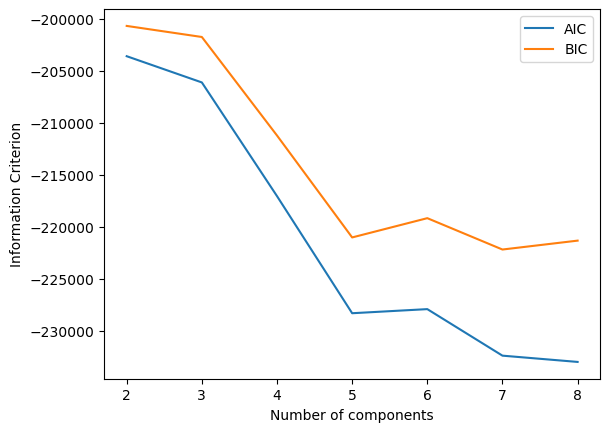

In [50]:
# Plotting AIC and BIC for different number of components

aic_values = []
bic_values = []
n_components_range = range(2, 9)

# Fitting the GMM for each number of components and collecting the AIC and BIC
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=1234, n_init=10)
    gmm.fit(X)
    aic_values.append(gmm.aic(X))
    bic_values.append(gmm.bic(X))

# Plotting the results
plt.plot(n_components_range, aic_values, label='AIC')
plt.plot(n_components_range, bic_values, label='BIC')
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.legend()
plt.show()

In [51]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

In [52]:
# Dropping columns for clustering but retain 'Like' and 'Like_n' for plotting
df_for_clustering = df.drop(columns=['Like', 'Like_n'])

In [53]:
# Identifying categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

In [54]:
# Applying one-hot encoding to categorical columns
encoder = OneHotEncoder(sparse=False)
encoded_categorical_data = encoder.fit_transform(df[categorical_columns])

# Dropping original categorical columns and adding encoded ones
df_encoded = df.drop(columns=categorical_columns)
df_encoded = pd.concat([df_encoded, pd.DataFrame(encoded_categorical_data)], axis=1)

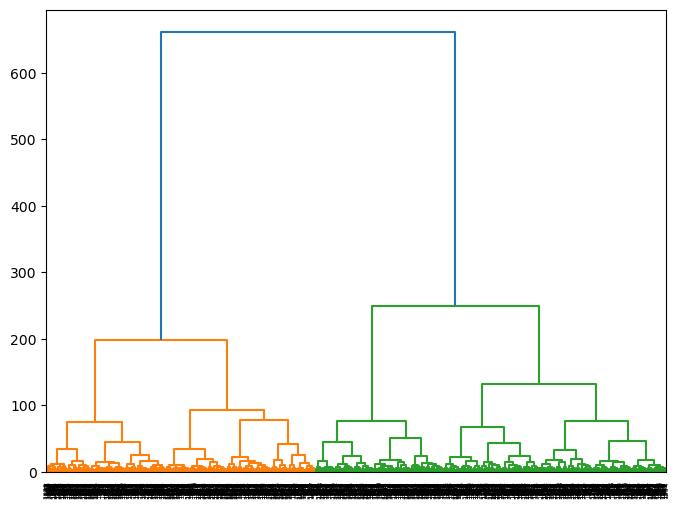

In [55]:
# Ensuring all data is numeric
MD_x = df_encoded.values

# Performing hierarchical clustering
linked = linkage(pdist(MD_x), method='ward')

# Plotting dendrogram
plt.figure(figsize=(8, 6))
dendrogram(linked)
plt.show()

In [56]:
# Clustering with KMeans
kmeans = KMeans(n_clusters=4, random_state=1234)
kmeans.fit(MD_x)
k4 = kmeans.labels_

# Add cluster labels to DataFrame
df['k4'] = k4

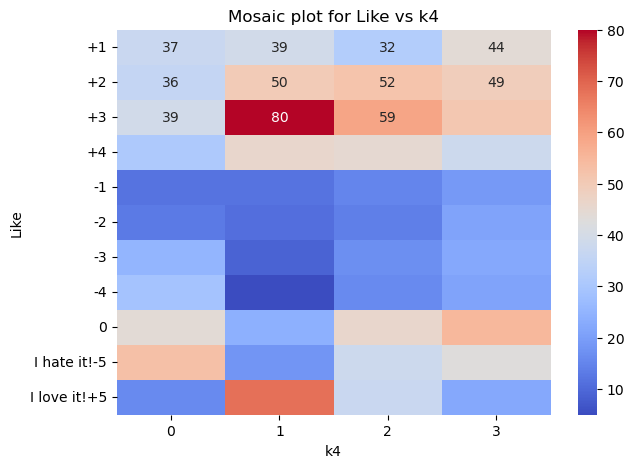

In [57]:
# Mosaic plot for 'Like' and 'k4'
like_k4_crosstab = pd.crosstab(df['Like'], df['k4'])
plt.figure(figsize=(7, 5))
sns.heatmap(like_k4_crosstab, annot=True, cmap='coolwarm', fmt='d')
plt.title('Mosaic plot for Like vs k4')
plt.show()

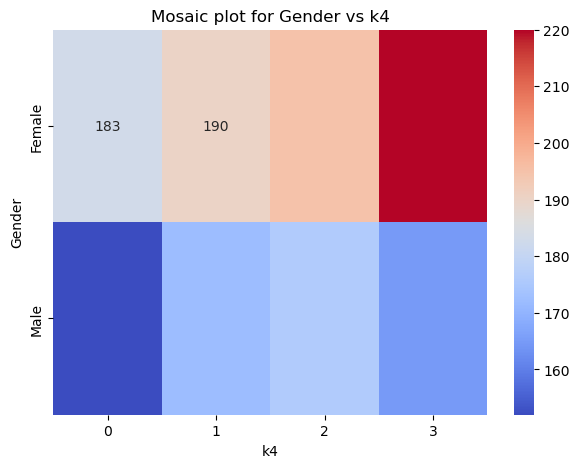

In [58]:
# Mosaic plot for 'Gender' and 'k4'
gender_k4_crosstab = pd.crosstab(df['Gender'], df['k4'])
plt.figure(figsize=(7, 5))
sns.heatmap(gender_k4_crosstab, annot=True, cmap='coolwarm', fmt='d')
plt.title('Mosaic plot for Gender vs k4')
plt.show()

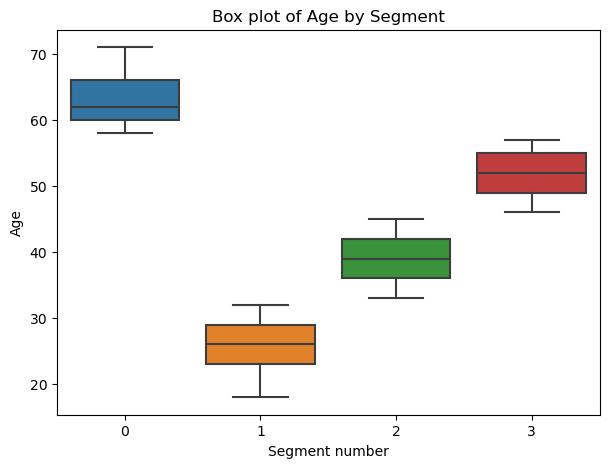

In [59]:
# Box plot for age by segment
plt.figure(figsize=(7, 5))
sns.boxplot(x='k4', y='Age', data=df)
plt.xlabel('Segment number')
plt.ylabel('Age')
plt.title('Box plot of Age by Segment')
plt.show()

In [60]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder

In [66]:
# Defining features
features = ['Like_n', 'Age']

# One-hot encode the 'Gender' column if not already done
if 'Gender' in df.columns:
    df = pd.get_dummies(df, columns=['Gender'], drop_first=True)

# One-hot encode the 'VisitFrequency' column
df = pd.get_dummies(df, columns=['VisitFrequency'], drop_first=True)

# Update features list to include the newly created dummy variables
features += [col for col in df.columns if col.startswith('Gender_') or col.startswith('VisitFrequency_')]

# Verify the columns in the DataFrame
print(df.columns)

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age', 'Like_n',
       'k4', 'Gender_Male', 'VisitFrequency_More than once a week',
       'VisitFrequency_Never', 'VisitFrequency_Once a month',
       'VisitFrequency_Once a week', 'VisitFrequency_Once a year'],
      dtype='object')


In [67]:
# Fit the decision tree
tree = DecisionTreeClassifier(random_state=1234)
tree.fit(df[features], (df['k4'] == 3).astype(int))

DecisionTreeClassifier(random_state=1234)

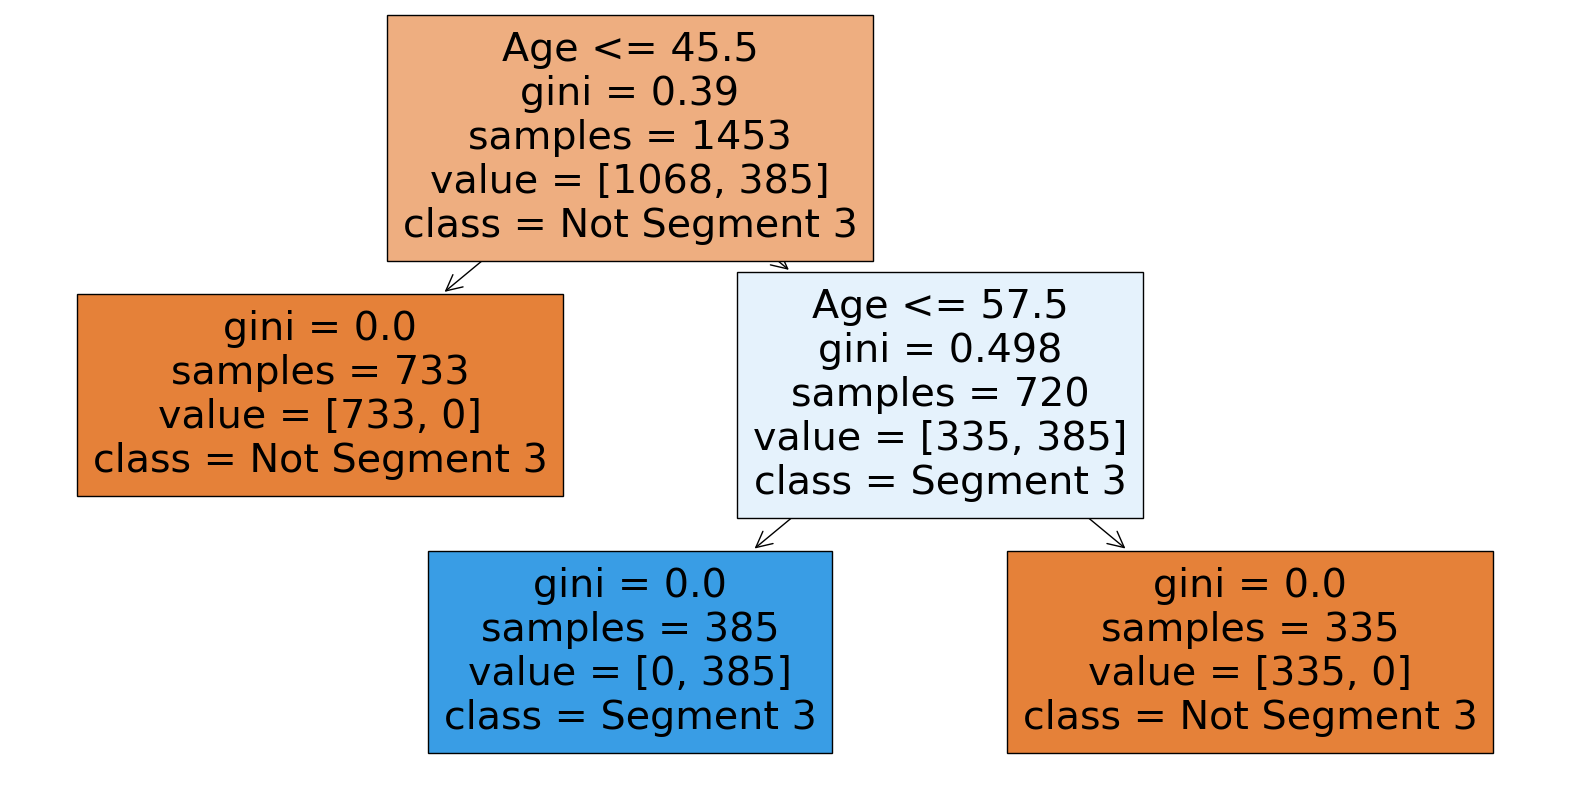

In [68]:
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=features, class_names=['Not Segment 3', 'Segment 3'], filled=True)
plt.show()

In [74]:
print(df.columns)

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age', 'Like_n',
       'k4', 'Gender_Male', 'VisitFrequency_More than once a week',
       'VisitFrequency_Never', 'VisitFrequency_Once a month',
       'VisitFrequency_Once a week', 'VisitFrequency_Once a year'],
      dtype='object')


In [75]:
# List of visit frequency columns
visit_frequency_columns = [
    'VisitFrequency_More than once a week',
    'VisitFrequency_Never',
    'VisitFrequency_Once a month',
    'VisitFrequency_Once a week',
    'VisitFrequency_Once a year'
]

# Calculating means for each visit frequency column by segment
visit_means = {col: df.groupby('k4')[col].mean() for col in visit_frequency_columns}

# Calculating mean for Like_n by segment
like_means = df.groupby('k4')['Like_n'].mean()

# Calculating proportion of Females by segment (1 - proportion of Males)
female_means = df.groupby('k4')['Gender_Male'].apply(lambda x: 1 - x.mean())

# Display the means
print("VisitFrequency means by segment:")
for col, means in visit_means.items():
    print(f"\n{col} means by segment:")
    print(means)

print("\nLike_n means by segment:")
print(like_means)

print("\nProportion of Females by segment:")
print(female_means)

VisitFrequency means by segment:

VisitFrequency_More than once a week means by segment:
k4
0    0.023881
1    0.074586
2    0.018868
3    0.031169
Name: VisitFrequency_More than once a week, dtype: float64

VisitFrequency_Never means by segment:
k4
0    0.176119
1    0.046961
2    0.061995
3    0.083117
Name: VisitFrequency_Never, dtype: float64

VisitFrequency_Once a month means by segment:
k4
0    0.214925
1    0.345304
2    0.363881
3    0.277922
Name: VisitFrequency_Once a month, dtype: float64

VisitFrequency_Once a week means by segment:
k4
0    0.080597
1    0.245856
2    0.202156
3    0.114286
Name: VisitFrequency_Once a week, dtype: float64

VisitFrequency_Once a year means by segment:
k4
0    0.247761
1    0.102210
2    0.137466
3    0.210390
Name: VisitFrequency_Once a year, dtype: float64

Like_n means by segment:
k4
0    1.038806
1    1.651934
2    1.339623
3    1.397403
Name: Like_n, dtype: float64

Proportion of Females by segment:
k4
0    0.546269
1    0.524862
2    0.

In [83]:
# Converting dictionaries to pandas Series
visit_means_series = pd.Series(visit_means)
like_means_series = pd.Series(like_means)
female_means_series = pd.Series(female_means)

# Printing indexes to check consistency
print("Visit Means Index:", visit_means_series.index)
print("Like Means Index:", like_means_series.index)
print("Female Means Index:", female_means_series.index)

Visit Means Index: Index(['VisitFrequency_More than once a week', 'VisitFrequency_Never',
       'VisitFrequency_Once a month', 'VisitFrequency_Once a week',
       'VisitFrequency_Once a year'],
      dtype='object')
Like Means Index: Index([0, 1, 2, 3], dtype='int32', name='k4')
Female Means Index: Index([0, 1, 2, 3], dtype='int32', name='k4')


In [84]:
# Finding common index
common_index = visit_means_series.index.intersection(like_means_series.index).intersection(female_means_series.index)

# Aligning Series
visit_means_aligned = visit_means_series.loc[common_index]
like_means_aligned = like_means_series.loc[common_index]
female_means_aligned = female_means_series.loc[common_index]

# Converting aligned Series to lists
visit_means_values = visit_means_aligned.values
like_means_values = like_means_aligned.values
female_means_values = female_means_aligned.values

In [85]:
# Printing lengths to ensure they match
print(f"Length of visit_means_values: {len(visit_means_values)}")
print(f"Length of like_means_values: {len(like_means_values)}")
print(f"Length of female_means_values: {len(female_means_values)}")

Length of visit_means_values: 0
Length of like_means_values: 0
Length of female_means_values: 0


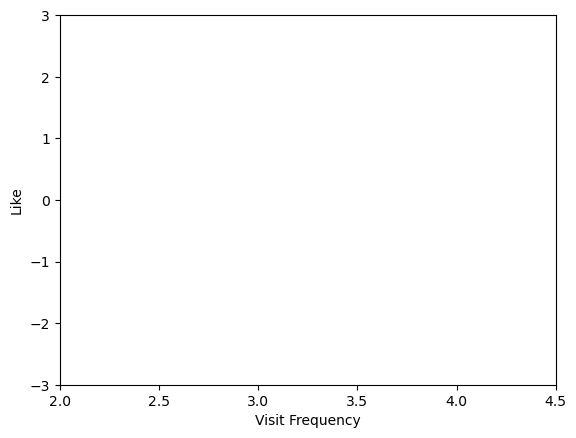

In [86]:
# Plot visit frequency vs like
plt.scatter(visit_means_values, like_means_values, s=1000 * np.array(female_means_values), alpha=0.5)
for i, txt in enumerate(common_index):
    plt.annotate(txt, (visit_means_values[i], like_means_values[i]))
plt.xlim(2, 4.5)
plt.ylim(-3, 3)
plt.xlabel('Visit Frequency')
plt.ylabel('Like')
plt.show()